### References:
1. [Analysing time-series with pandas](https://towardsdatascience.com/analyzing-time-series-data-in-pandas-be3887fdd621)
2. [Time Series End-to-End](https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b)
3. [Missing values imputation with EM algorithm](https://joon3216.github.io/research_materials/2019/em_imputation_python.html)

In [233]:
import pandas as pd
import numpy as np 
import plotly.graph_objects as go
import json

In [83]:
logins_df = pd.read_json('../ultimate_challenge/logins.json')
data_df = pd.read_json('../ultimate_challenge/ultimate_data_challenge.json')

## Exploratory Data Analysis

In [84]:
logins_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [167]:
logins_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 93142 entries, 1970-01-01 20:13:18 to 1970-04-13 18:54:23
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   count   93142 non-null  int64
 1   hour    93142 non-null  int64
 2   day     93142 non-null  int64
dtypes: int64(3)
memory usage: 5.3 MB


In [85]:
logins_df['login_time'] = logins_df['login_time'].astype('datetime64')
logins_df = logins_df.set_index('login_time')
logins_df['count'] = 1
logins_agg = []
for time_interval in ['15T', 'H', 'D']:
    logins_agg.append(logins_df.resample(time_interval).count()['count'])

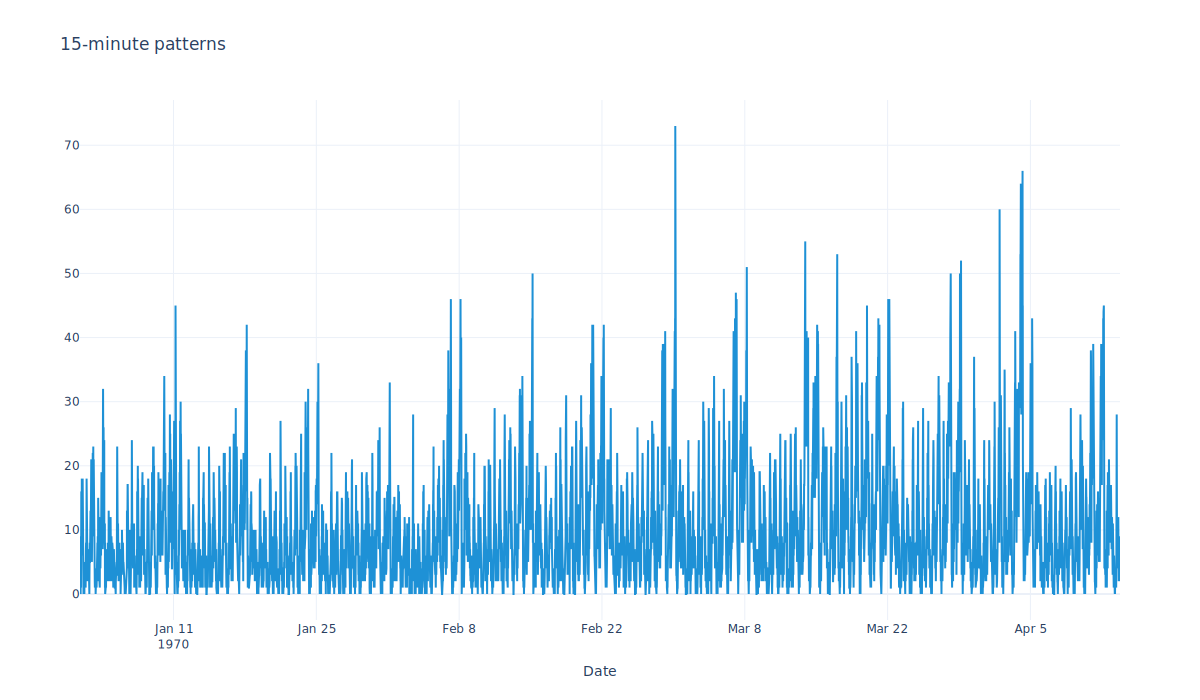

In [86]:
THEME = 'light'
trace_all = dict(x = logins_agg[0].index,
                 y = logins_agg[0].values,
                 mode = 'lines',
                 marker = dict(color = '#1e91d6'))
layout = dict(title = '15-minute patterns', 
              xaxis_title = 'Date', 
              autosize = False, 
              template = "plotly_dark" if THEME.lower() == 'dark' else 'plotly_white')
fig = go.Figure(data = go.Scatter(trace_all),
                layout = layout)
f1 = go.FigureWidget(fig)
f1.show('svg', width = '1200', height = '700')

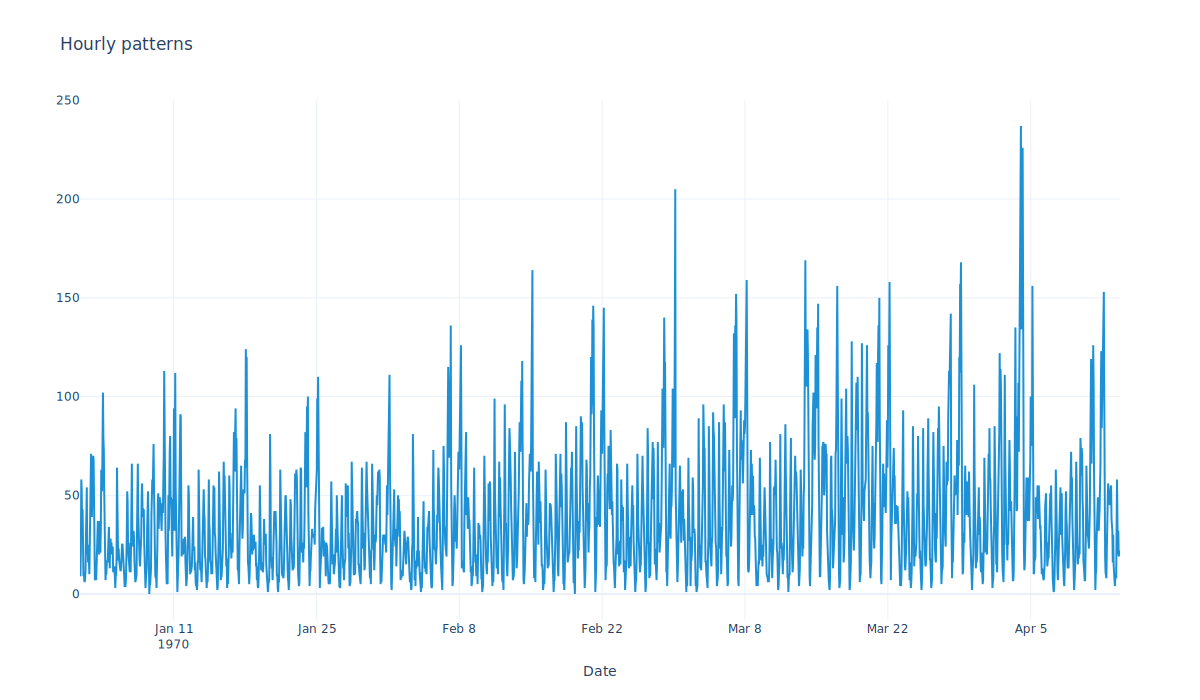

In [87]:
trace_all = dict(x = logins_agg[1].index,
                 y = logins_agg[1].values,
                 mode = 'lines',
                 marker = dict(color = '#1e91d6'))
layout = dict(title = 'Hourly patterns', 
              xaxis_title = 'Date', 
              autosize = False, 
              template = "plotly_dark" if THEME.lower() == 'dark' else 'plotly_white')
fig = go.Figure(data = go.Scatter(trace_all),
                layout = layout)
f1 = go.FigureWidget(fig)
f1.show('svg', width = '1200', height = '700')

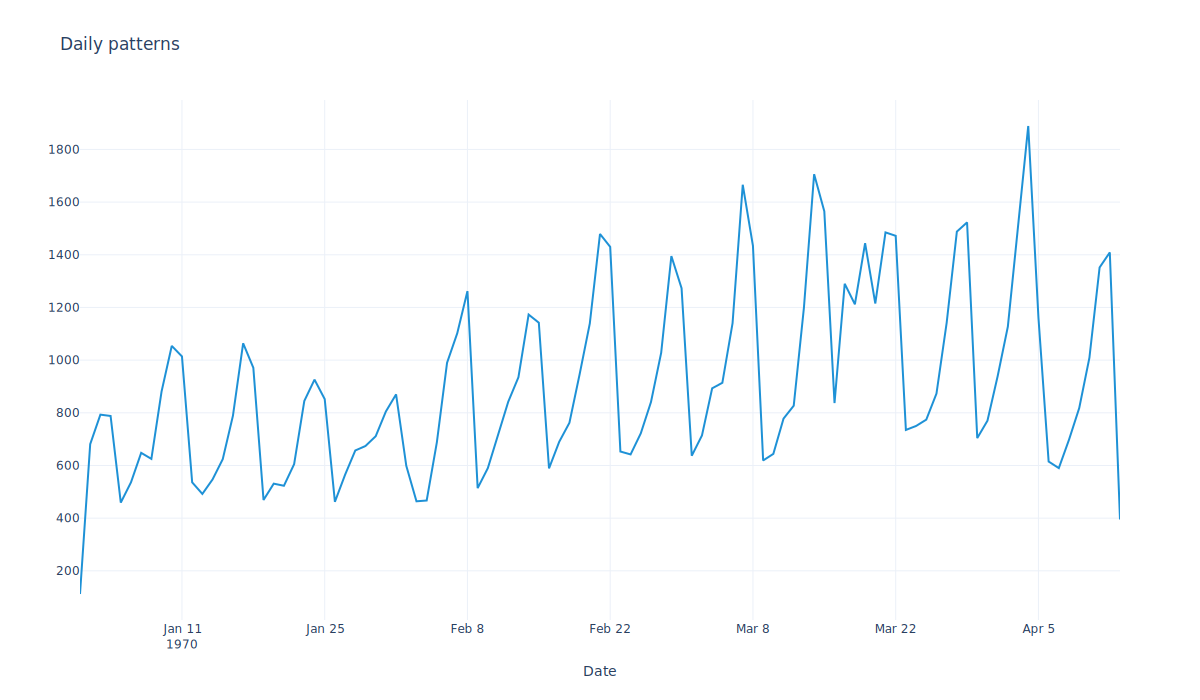

In [127]:
trace_daily = dict(x = logins_agg[2].index,
                        y = logins_agg[2].values,
                 mode = 'lines',
                 name = 'daily',
                 marker = dict(color = '#1e91d6'))
layout = dict(title = 'Daily patterns', 
              xaxis_title = 'Date', 
              autosize = False, 
              template = "plotly_dark" if THEME.lower() == 'dark' else 'plotly_white')
fig = go.Figure(data = [go.Scatter(trace_daily)],
                layout = layout)                
f1 = go.FigureWidget(fig)
f1.show('svg', width = '1200', height = '700')

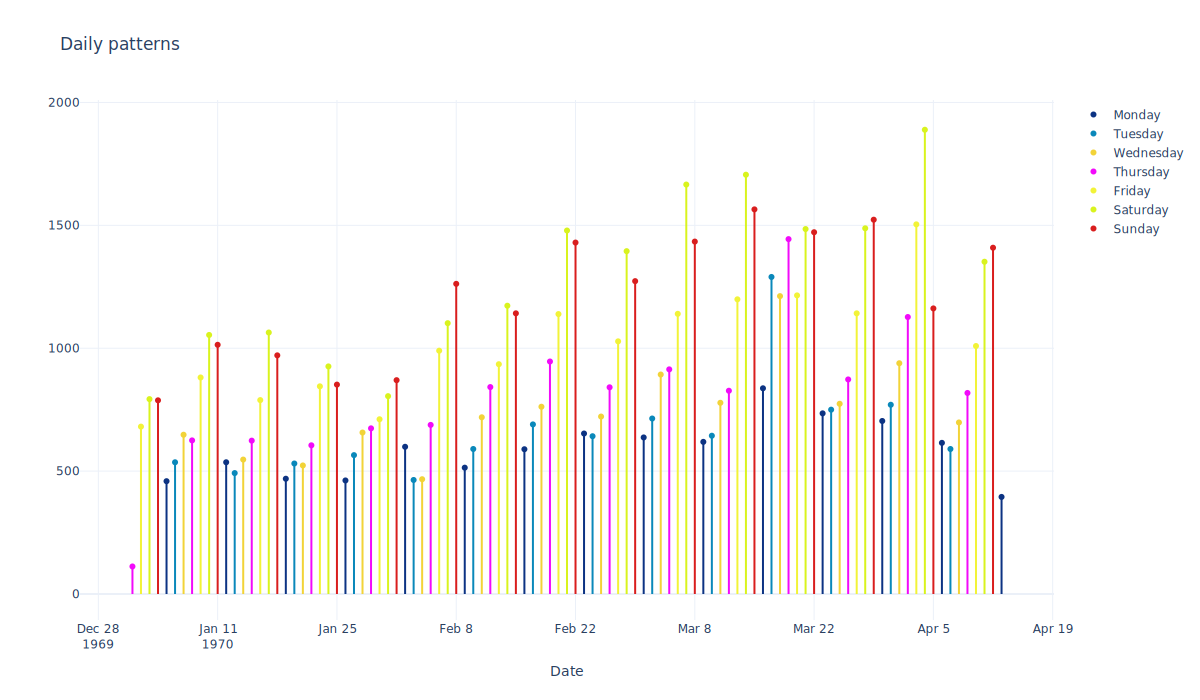

In [124]:
Portland_colours = ['rgb(12, 51, 131)', 
                    'rgb(10, 136, 186)', 
                    'rgb(242, 211, 56)',
                    'rgb(242, 10, 250)', 
                    'rgb(242, 243, 56)', 
                    'rgb(217, 243, 30)',
                    'rgb(217, 30, 30)']
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
trace_weekdaywise = [dict(x = logins_agg[2].index,
                 y = logins_agg[2].reset_index()
                                  .apply(lambda x: x['count'] if x['login_time'].day_name() == weekday_name else None, axis = 1)
                                  .values,
                 error_y = dict(type = 'data',
                                symmetric = False,
                                arrayminus = logins_agg[2].reset_index()
                                                          .apply(lambda x: x['count'] if x['login_time']
                                                                                         .day_name() == weekday_name else None, axis = 1)
                                                          .values,
                                array = 0 * list(logins_agg[2].index), 
                                width = 0,
                                color = day_color),
                 mode = 'markers',
                 name = weekday_name,
                 marker = dict(color = day_color)) for weekday_name, day_color in zip(days, Portland_colours)]
layout = dict(title = 'Daily patterns', 
              xaxis_title = 'Date', 
              autosize = False, 
              template = "plotly_dark" if THEME.lower() == 'dark' else 'plotly_white')
fig = go.Figure(data = [go.Scatter(trace) for trace in trace_weekdaywise],
                layout = layout)                
f1 = go.FigureWidget(fig)
f1.show('svg', width = '1200', height = '700')

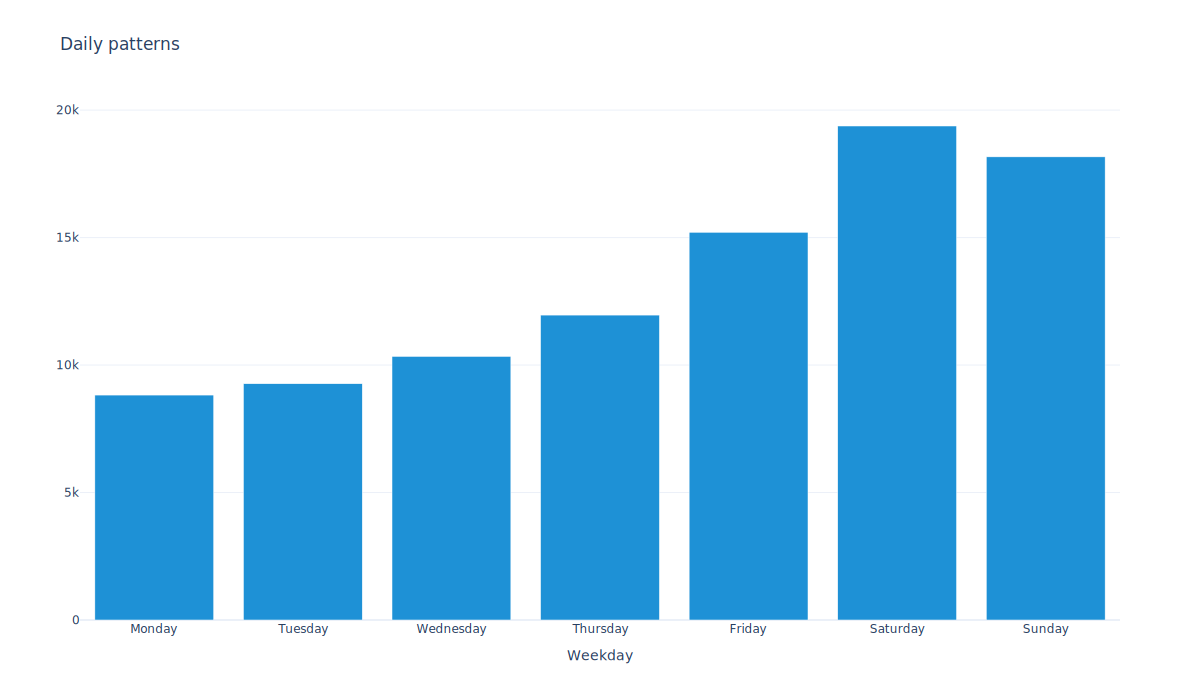

In [146]:
logins_df['hour'] = logins_df.index.hour
logins_df['day'] = logins_df.index.weekday
bar_weekday = dict(y = logins_df.groupby('day').sum()['count'],
                    x = days,
                marker = dict(color = '#1e91d6'))
layout = dict(title = 'Weekday patterns', 
              xaxis_title = 'Weekday', 
              autosize = False, 
              template = "plotly_dark" if THEME.lower() == 'dark' else 'plotly_white')
fig = go.Figure(data = [go.Bar(bar_weekday)],
                layout = layout)                
f1 = go.FigureWidget(fig)
f1.show('svg', width = '1200', height = '700')

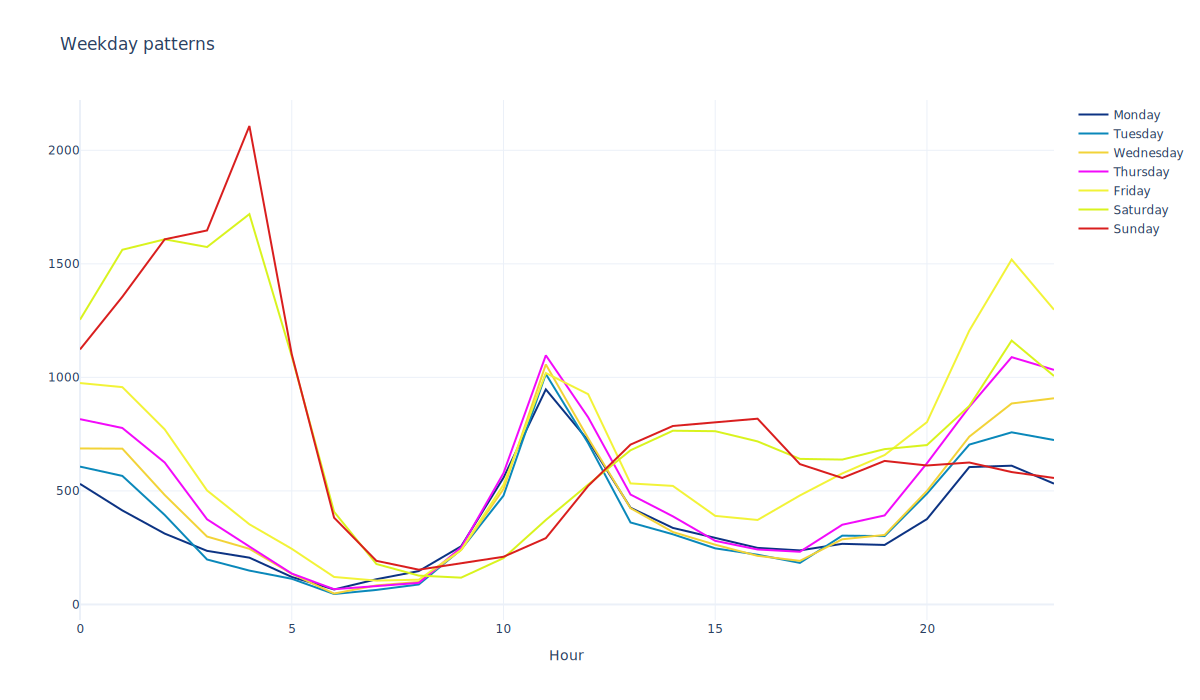

In [166]:
grouped = logins_df.groupby(['day', 'hour']).sum().reset_index()
bar_grouped = [dict(y = grouped[grouped['day'] == weekday_number]['count'],
                   x = grouped['hour'],
                   mode = 'lines',
                   name = day,
                   marker = dict(color = color)) for weekday_number, color, day in zip(range(7), Portland_colours, days)]
layout = dict(title = 'Weekday patterns', 
              xaxis_title = 'Hour', 
              autosize = False, 
              template = "plotly_dark" if THEME.lower() == 'dark' else 'plotly_white')
fig = go.Figure(data = [go.Scatter(bar) for bar in bar_grouped],
                layout = layout)                
f1 = go.FigureWidget(fig)
f1.show('svg', width = '1200', height = '700')

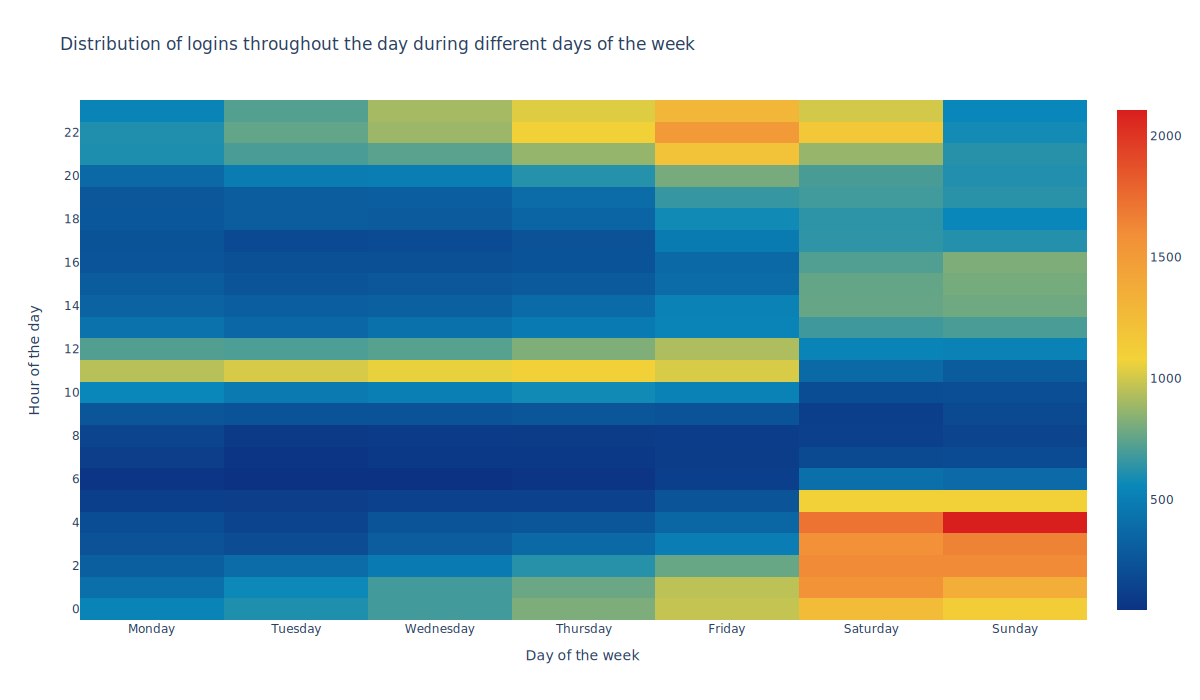

In [230]:
logins_hourly_by_weekday = logins_df.pivot_table(index = 'hour', columns = 'day', values = 'count', aggfunc = 'sum').rename({num:name for name, num in zip(days, range(7))}, axis = 1)
hourly_heatmap = dict(
                   z = logins_hourly_by_weekday.values,
                   x = logins_hourly_by_weekday.columns,
                   y = logins_hourly_by_weekday.index,
                   colorscale = 'Portland',
                   hoverongaps = False)
layout = dict(xaxis_nticks = 7,
              yaxis_nticks = 24,
              title = 'Distribution of logins throughout the day during different days of the week',
              xaxis_title = 'Day of the week',
              yaxis_title = 'Hour of the day')
fig = go.Figure(data = go.Heatmap(hourly_heatmap), layout = layout)
fig.show('svg', width = 1200, height = 700)

In [223]:
logins_hourly_by_weekday.index

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23],
           dtype='int64', name='hour')

Since the login data is not a financial time series, it most probably contains the following features:
<br>

1. Trends
2. Seasonality
3. Irregularity
4. Cyclic

<br>



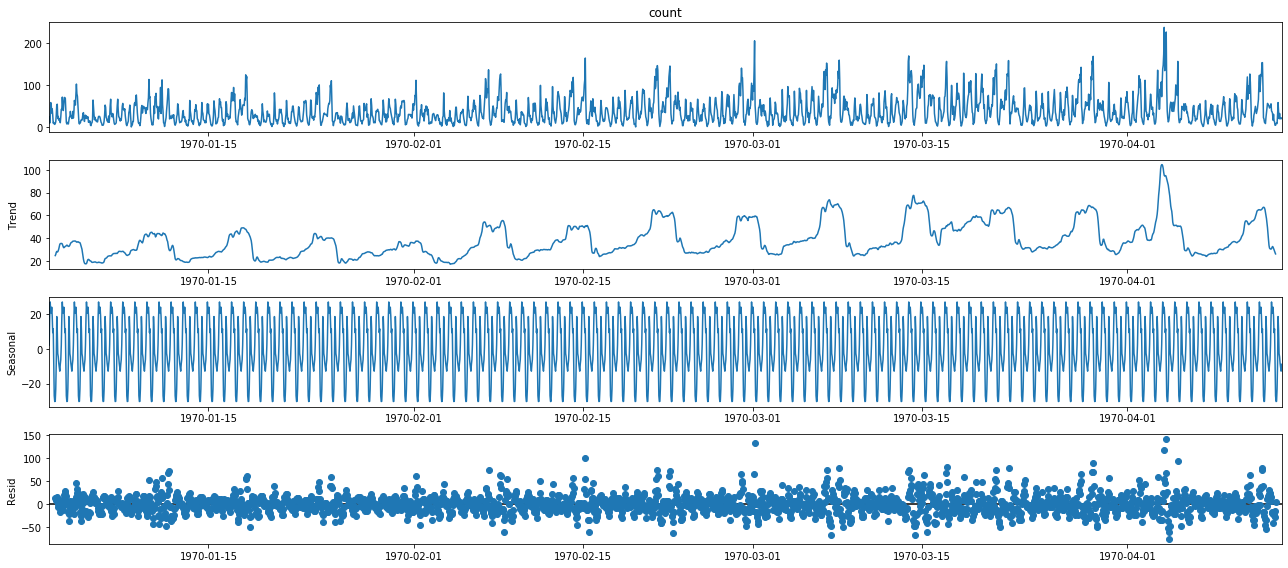

In [193]:
import statsmodels.api as sm 
from pylab import rcParams
import matplotlib.pyplot as plt
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(logins_df.resample('H').count()['count'], model = 'additive')
fig = decomposition.plot()
plt.show()

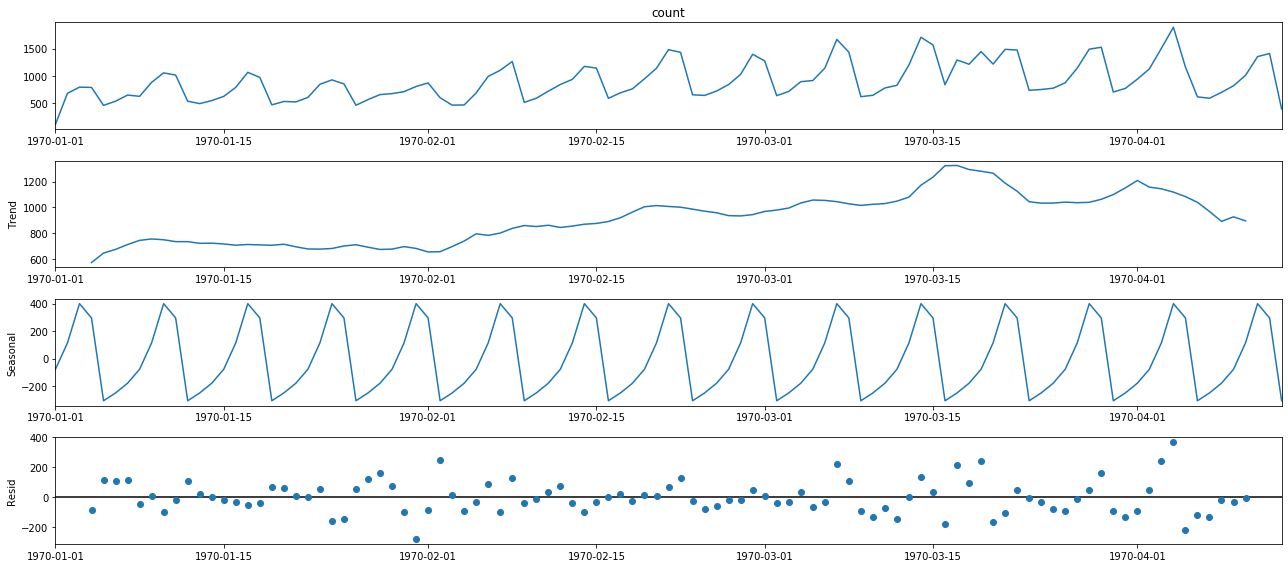

In [198]:
decomposition = sm.tsa.seasonal_decompose(logins_df.resample('D').count()['count'], model = 'additive')
fig = decomposition.plot()
plt.show()

In [208]:
mod = sm.tsa.statespace.SARIMAX(logins_df.resample('H').count()['count'])

In [209]:
results = mod.fit()
print(results.summary())

SARIMAX Results                                
Dep. Variable:                  count   No. Observations:                 2447
Model:               SARIMAX(1, 0, 0)   Log Likelihood              -10629.775
Date:                Fri, 22 May 2020   AIC                          21263.550
Time:                        19:38:57   BIC                          21275.155
Sample:                    01-01-1970   HQIC                         21267.768
                         - 04-13-1970                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9244      0.004    209.233      0.000       0.916       0.933
sigma2       347.0615      5.850     59.329      0.000     335.596     358.527
Ljung-Box (Q):                     1369.60   Jarque-Bera (JB):              2309.57

In [234]:
with open('../ultimate_challenge/ultimate_data_challenge.json') as inp_file:
    df = pd.DataFrame(json.load(inp_file))

df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [238]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [237]:
df.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

In [239]:
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
df['signup_date'] = pd.to_datetime(df['signup_date'])

In [240]:
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


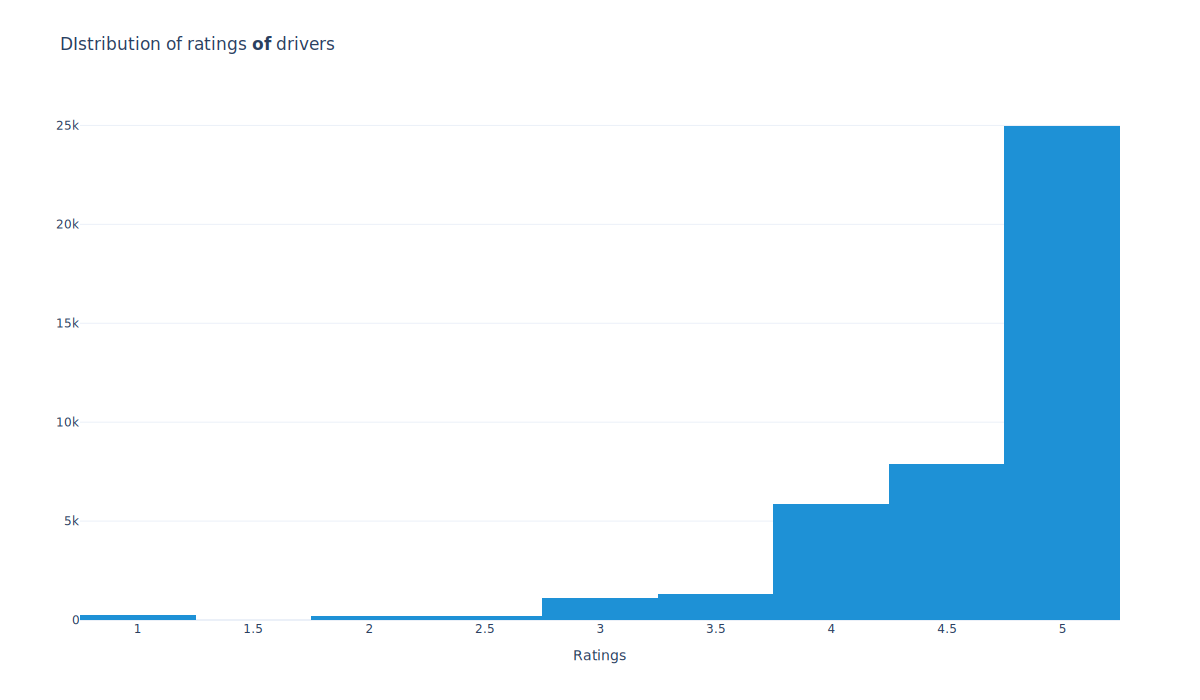

In [255]:
ratings_hist = dict(x = df['avg_rating_of_driver'],
                    nbinsx = 12,
                marker = dict(color = '#1e91d6'))
layout = dict(title = 'DIstribution of ratings <b>of</b> drivers', 
              xaxis_title = 'Ratings', 
              autosize = False, 
              template = "plotly_dark" if THEME.lower() == 'dark' else 'plotly_white')
fig = go.Figure(data = [go.Histogram(ratings_hist)],
                layout = layout)                
f = go.FigureWidget(fig)
f.show('svg', width = '1200', height = '700')

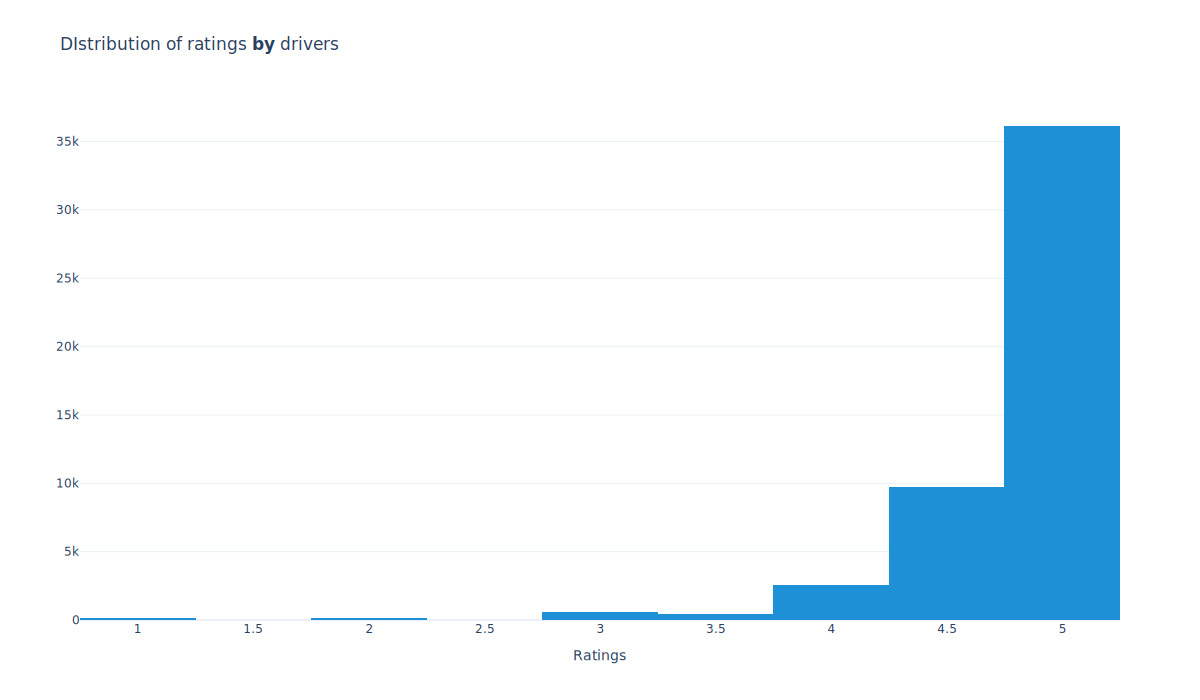

In [253]:
ratings_by_hist = dict(x = df['avg_rating_by_driver'],
                    nbinsx = 12,
                marker = dict(color = '#1e91d6'))
layout = dict(title = 'DIstribution of ratings <b>by</b> drivers', 
              xaxis_title = 'Ratings', 
              autosize = False, 
              template = "plotly_dark" if THEME.lower() == 'dark' else 'plotly_white')
fig = go.Figure(data = [go.Histogram(ratings_by_hist)],
                layout = layout)                
f = go.FigureWidget(fig)
f.show('svg', width = '1200', height = '700')

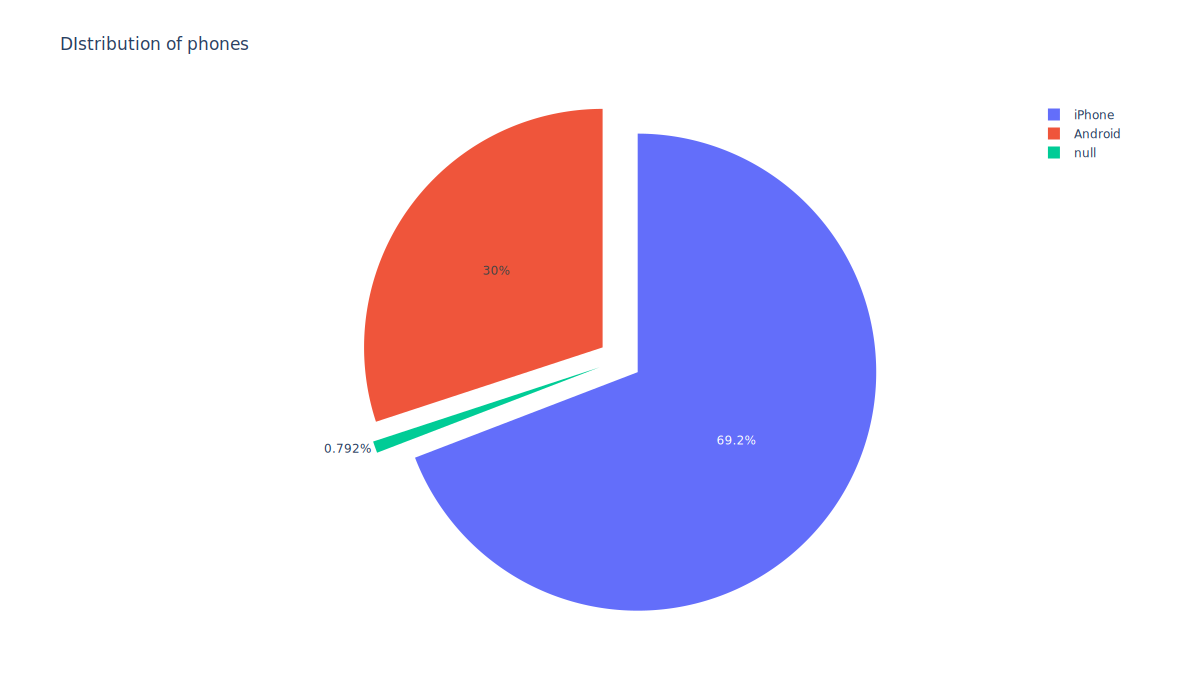

In [251]:
phone_hist = dict(labels = df['phone'], 
                    pull = 0.09)
layout = dict(title = 'DIstribution of phones', 
              autosize = False, 
              template = "plotly_dark" if THEME.lower() == 'dark' else 'plotly_white')
fig = go.Figure(data = [go.Pie(phone_hist)],
                layout = layout)                
f = go.FigureWidget(fig)
f.show('svg', width = '1200', height = '700')

In [259]:
df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].median(), inplace=True)
df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].median(), inplace=True)
df['phone'].fillna('iPhone', inplace=True)

Could have used other methods to fill in missing values

In [260]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   50000 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    50000 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [266]:
categorical_features = df.select_dtypes(exclude = ['int64', 'float64', 'datetime64']).columns
numerical_features = df.select_dtypes(include = ['int64', 'float64']).columns
for feature in numerical_features:
    non_outliers = ((df[feature] - df[feature].mean()) <= 3*df[feature].std())
    print(f'Number of observations in {feature} '\
          f'which are beyond 3 std-devs are: {50000 - non_outliers.sum()}')

Number of observations in trips_in_first_30_days which are beyond 3 std-devs are: 1082
Number of observations in avg_rating_of_driver which are beyond 3 std-devs are: 0
Number of observations in avg_surge which are beyond 3 std-devs are: 1142
Number of observations in surge_pct which are beyond 3 std-devs are: 1471
Number of observations in weekday_pct which are beyond 3 std-devs are: 0
Number of observations in avg_dist which are beyond 3 std-devs are: 959
Number of observations in avg_rating_by_driver which are beyond 3 std-devs are: 0


In [267]:
for feature in numerical_features:
    non_outliers = ((df[feature] - df[feature].mean()) <= 3*df[feature].std())
    df = df[non_outliers]

In [270]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46067 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    46067 non-null  object        
 1   trips_in_first_30_days  46067 non-null  int64         
 2   signup_date             46067 non-null  datetime64[ns]
 3   avg_rating_of_driver    46067 non-null  float64       
 4   avg_surge               46067 non-null  float64       
 5   last_trip_date          46067 non-null  datetime64[ns]
 6   phone                   46067 non-null  object        
 7   surge_pct               46067 non-null  float64       
 8   ultimate_black_user     46067 non-null  bool          
 9   weekday_pct             46067 non-null  float64       
 10  avg_dist                46067 non-null  float64       
 11  avg_rating_by_driver    46067 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [278]:
from collections import Counter
for feature in categorical_features:
    counts = Counter(df[feature])
    counts = {k:(str(round(v/46067*100, 2))+('%')) for k,v in counts.items()}
    print(f'Proportion of categories in {feature} is {counts}\n')

Proportion of categories in city is {"King's Landing": '20.23%', 'Astapor': '32.94%', 'Winterfell': '46.83%'}

Proportion of categories in phone is {'iPhone': '69.97%', 'Android': '30.03%'}

Proportion of categories in ultimate_black_user is {True: '38.11%', False: '61.89%'}



In [281]:
all(df['signup_date'].dt.month == 1)

True

In [285]:
df['retained'] = pd.Series((df['last_trip_date'] >= '2014-06-01').map(int))

In [286]:
df.drop('last_trip_date', axis = 1, inplace = True)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,4,2014-01-25,4.7,1.10,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,iPhone,20.0,True,80.0,2.36,4.9,1
5,Winterfell,2,2014-01-09,3.5,1.00,iPhone,0.0,True,100.0,10.56,5.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25,5.0,1.00,iPhone,0.0,False,100.0,5.63,4.2,1
49996,Astapor,1,2014-01-24,4.9,1.00,iPhone,0.0,False,0.0,0.00,4.0,0
49997,Winterfell,0,2014-01-31,5.0,1.00,Android,0.0,True,100.0,3.86,5.0,0
49998,Astapor,2,2014-01-14,3.0,1.00,iPhone,0.0,False,100.0,4.58,3.5,0


In [287]:
df.drop('signup_date', axis = 1, inplace = True)

In [292]:
final_df = pd.get_dummies(df, columns = categorical_features)
X, y = final_df.drop('retained', axis = 1).values, final_df['retained'].values
print(X.shape, y.shape)

(46067, 14) (46067,)


In [301]:
Perc_retained = Counter(final_df['retained'])[1]/46067
print(f'Percentage of users retained is: {round((Perc_retained*100), 2)}%')

Percentage of users retained is: 37.89%


In [303]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier

In [306]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10, stratify = y)

In [311]:
clf = DecisionTreeClassifier(max_depth = 3)
Y_test = clf.fit(X_train, y_train).predict(X_test)
confusion_matrix(y_test, Y_test)

array([[5106,  617],
       [1765, 1726]])

In [325]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(criterion = 'gini', max_depth = 5, random_state = 10, class_weight = 'balanced_subsample')
Y_test = clf.fit(X_train, y_train).predict(X_test)
confusion_matrix(y_test, Y_test)

array([[4481, 1242],
       [ 886, 2605]])

In [333]:
feature_importances = clf.feature_importances_
feature_importances = pd.Series(feature_importances, index = final_df.drop('retained', axis = 1).columns)
print(feature_importances.sort_values(ascending = False))

avg_rating_by_driver         0.179678
surge_pct                    0.178975
city_King's Landing          0.145806
avg_surge                    0.104903
weekday_pct                  0.098974
phone_iPhone                 0.070454
phone_Android                0.054837
ultimate_black_user_True     0.037928
trips_in_first_30_days       0.033152
city_Astapor                 0.032957
ultimate_black_user_False    0.029360
avg_rating_of_driver         0.016532
city_Winterfell              0.009352
avg_dist                     0.007089
dtype: float64


Solution:
With regard to the key measure of success, I would choose a metric that describes the percentage of time a driver spends in either city. At this point, since the drivers tend to be exclusive to both cities, the metric for the average Gotham driver would look something like 100% time in Gotham and 0% time in Metropolis. In a perfectly successful experiment, we would see the metric shift closer to 50% time in Gotham and 50% time in Metropolis. In a less successful experiment, we would see the metric shift closer to 75% time in Gotham and 25% time in Metropolis. If the metric for the average Gotham driver flips to favor time in Metropolis, there is something wrong and we have incentivized time in Metropolis too much and we may see the average Metropolis driver stay in Metropolis and vice versa. Using a metric such as this one allows us to track real activity in the drivers of both cities and the maximization of such a metric results in a balance of time in both cities.

We should also keep in mind revenue as a secondary metric to look at, since this is usually the main reason for solving a business problem. Using revenue as a main metric, however, can be problematic because the real reasons for movements in revenue are not always apparent. Maximizing revenue may be good for short-term bottom line results, but not great for long-term growth. For example, seeking to maximize revenue may result in incentives to drive in only Gotham or only Metropolis due to increased fares in either city, which would cause us to alienate an entire group of drivers and customers.

I would set up the experiment in the following way:

Current scenario: Average time split for the average Gotham driver is close to 100% Gotham, 0% Metropolis. Average time split for the average Metropolis driver is close to 100% Metropolis, 0% Gotham.
Goal: Push the average time split for both the average Gotham driver and average Metropolis closer to 50% Gotham, 50% Metropolis.

The experiment consists of offering full reimbursements to all toll costs, and can be tested during two times of the year: 1) when it is easy to drive (summer) and 2) when it is difficult to drive (winter). For the purposes of this challenge, let's focus on a typical summer month when the experiment will be run for one month.

We can measure the results of the experiment with a one-tailed z-test where we can test whether the average Gotham driver's time spent in Gotham is meaningfully below 100% and whether the average Metropolis driver's time spent in Metropolis is meaningully below 100%. Alternatively, we could also test whether either time spent is meaningfully above 0% outside of a driver's native city. A one-tailed test is appropriate since we want to test whether the average percent of time has changed to either above 0% or below 100% (depending on the scenario we want to test as described previously). A z-test is appropriate because we can obtain a rather large sample size (easily >30) and we likely know or can find the population's standard deviation under normal operation.

We can interpret the results in the form of a confidence interval. To be safe, a 95% confidence interval could be useful. In this way, we can present our findings such as: We are 95% confident that the mean percent of time the average Gotham driver spends driving in Gotham has dropped to 75% give or take 5%. In this way we can easily show whether the test worked and whether drivers from each city are spending more time outside of their native cities. Two caveats, as described when exploring metrics, might be that:

Profits may have dropped depending on how many drivers move between each city. It is possible that, since demand for drivers has not been increased, profits will drop because the company is now reimbursing toll expenses while not increasing revenue. This may be of lesser concern because our main goal is to incentivize drivers to operate in both cities.
We may find that we incentivised too well. For example, if we are 95% confident that the mean percent of time the average Gotham driver spends driving in Gotham has dropped to 35% give or take 5%, we could see that the metric for Metropolis drivers has not moved meaningfully. In this case, we should incentivize differently since it may not always be a good thing that the metrics have move in a statistically significant way.